# Optical Simulation

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from numpy import arcsin,sin,cos,sqrt,exp,pi,array,identity,dot
import enum
Pol = enum.Enum('Pol','s p sp')

## Snell's Law
\begin{equation*}
 n_{0}\sin\phi_{0} = n_{1}\sin\phi_{1} \\
 \phi_{1} = \sin^{-1} \left(\frac{n_{0}}{n_{1}}\sin\phi_{0}\right)
\end{equation*}

In [3]:
def SnellLaw(n0,n1,angle):
    return arcsin(n0/n1*sin(angle))

## Effective refractive index
\begin{eqnarray*}
 \eta_{j} &=& -n_{j}\cos\phi_{j}  & :s-polarized\\
          &=&\frac{n_{j}}{\cos \phi_{j}} & :p-polarized
\end{eqnarray*}

In [4]:
def EffectiveRefractiveIndex(n,angle,pol):
    if(pol == Pol.s):
        return -n*cos(angle)
    else:
        return n/cos(angle)

## Fresnel coefficient
\begin{equation*}
 r = \frac{\eta_{0}-\eta_{1}}{\eta_{0}+\eta_{1}} \\
 t = \sqrt{\frac{n_{0} \cos \phi_{0}}{n_{1} \cos \phi_{1}}}\cdot\frac{2\sqrt{\eta_{0}\eta_{1}}}{\eta_{0}+\eta_{1}}
\end{equation*}

In [5]:
def FresnelCoefficient(n0,n1,angle0,pol):
    eta0=EffectiveRefractiveIndex(n0,angle0,pol)
    angle1=SnellLaw(n0,n1,angle0)
    eta1=EffectiveRefractiveIndex(n1,angle1,pol)
    r = (eta0-eta1)/(eta0+eta1)
    t = sqrt(n0*cos(angle0)/(n1*cos(angle1)))*2*sqrt(eta0*eta1)/(eta0+eta1)
    return r,t 

## Phase difference
\begin{equation*}
 2\delta = \frac{4\pi}{\lambda}nd\cos\phi
\end{equation*}

In [6]:
def PhaseDifference(n,d,angle,wl):
    return 2*pi*n*d*cos(angle)/wl

## Specific Matrix
\begin{equation*}
M_{j} = \left(
         \begin{array}{cc}
          \cos \delta_{j} & i \eta_{j}^{-1} \sin \delta_{j} \\
          i \eta_{j} \sin \delta_{j}& \cos \delta_{j}\\
         \end{array}
        \right)
\end{equation*}

In [7]:
class Material:
    def __init__(self,n={550:1.5}):
        self.n = n
    def getIndex(self,wl):
        value = self.n.get(wl)
        if value == None:
            nl = self.n.keys()
            l = [x for x in nl if x < wl]
            h = [x for x in nl if x > wl]
            if len(l) != 0 and len(h) != 0:
                x1 = max(l)
                x2 = min(h)
                y1 = self.n.get(x1)
                y2 = self.n.get(x2)
                value = (y2-y1)/(x2-x1)*(wl-x1)+y1
            elif len(l) != 0:
                value = self.n.get(max(l))
            elif len(h) != 0:
                value = self.n.get(min(h))
            else:
                value = None
        return value

In [8]:
class Layer:
    def __init__(self,material,thickness):
        self.material = material
        self.thickness = thickness
    def getSpecificMatrix(self,n0,angle0,wl,pol):
        n = self.material.getIndex(wl)
        angle = SnellLaw(n0,n,angle0)
        delta = PhaseDifference(n,self.thickness,angle,wl)
        eta = EffectiveRefractiveIndex(n,angle,pol)
        return array([[cos(delta),1j/eta*sin(delta)],[1j*eta*sin(delta),cos(delta)]])

## Semi-infinite Model
\begin{equation*}
 R=|r_{1}|^{2} \\
 T=\frac{n_{1} \cos \phi_{1}}{n_{0} \cos \phi_{0}}|t_{1}|^{2} 
\end{equation*}

In [9]:
def SemiInfinite(matIn,matOut,angle0,wl,pol):
    n0 = matIn.getIndex(wl)
    n1 = matOut.getIndex(wl)
    angle1 = SnellLaw(n0,n1,angle0)
    r,t = FresnelCoefficient(n0,n1,angle0,pol)
    rr = abs(r)**2
    tt = n1*cos(angle1)/(n0*cos(angle0))*abs(t)**2
    return rr,tt

## Monolayer
\begin{equation*}
 R=\frac{r_{1}+r_{2}\mathrm{e}^{-2i\delta_{1}}}{1+r_{1}r_{2}\mathrm{e}^{-2i\delta_{1}}} \\
 T=\frac{t_{1}t_{2}\mathrm{e}^{-i\delta_{1}}}{1+r_{1}r_{2}\mathrm{e}^{-2i\delta_{1}}}
\end{equation*}

    n0
------------
    n,t
------------
    n1

In [10]:
def Monolayer(matIn,matOut,layer,angle0,wl,pol):
    n0 = matIn.getIndex(wl)
    n1 = matOut.getIndex(wl)
    n = layer.material.getIndex(wl)
    thickness = layer.thickness
    angle = SnellLaw(n0,n,angle0)
    angle1 = SnellLaw(n0,n1,angle0)
    r1,t1 = FresnelCoefficient(n0,n,angle0,pol)
    r2,t2 = FresnelCoefficient(n,n1,angle,pol)
    delta1 = PhaseDifference(n,thickness,angle,wl)
    r = (r1+r2*exp(-2j*delta1))/(1+r1*r2*exp(-2j*delta1))
    t = t1*t2*exp(-2j*delta1)/(1+r1*r2*exp(-2j*delta1))
    rr = abs(r)**2
    tt = n1*cos(angle1)/(n0*cos(angle0))*abs(t)**2
    return rr,tt

## Use Specific Matrix
\begin{equation*}
 R=\frac{\eta_{0}(m_{11}+\eta_{N+1}m_{12})-(m_{21}+\eta_{N+1}m_{22})}{\eta_{0}(m_{11}+\eta_{N+1}m_{12})+(m_{21}+\eta_{N+1}m_{22})} \\
 T=\gamma\frac{2\eta_{0}}{\eta_{0}(m_{11}+\eta_{N+1}m_{12})+(m_{21}+\eta_{N+1}m_{22})}
\end{equation*}

\begin{equation*}
\gamma = \left\{
 \begin{array}{l}
  1 & :s-polarized\\
  \frac{\cos\phi_{0}}{\cos\phi_{N+1}} & :p-polarized
 \end{array}
 \right.
\end{equation*}

In [11]:
def Multilayer(matIn,matOut,layers,angle0,wl,pol):
    n0 = matIn.getIndex(wl)
    n1 = matOut.getIndex(wl)
    angle1 = SnellLaw(n0,n1,angle0)
    eta0 = EffectiveRefractiveIndex(n0,angle0,pol)
    eta1 = EffectiveRefractiveIndex(n1,angle1,pol)
    if(pol == Pol.s):
        gamma = 1
    else:
        gamma = cos(angle0)/cos(angle1)
    mat = identity(2)
    for layer in layers:
        mat = dot(mat,layer.getSpecificMatrix(n0,angle0,wl,pol))  
    r = (eta0*(mat[0,0]+eta1*mat[0,1])-(mat[1,0]+eta1*mat[1,1]))/(eta0*(mat[0,0]+eta1*mat[0,1])+(mat[1,0]+eta1*mat[1,1]))
    t = gamma*2*eta0/(eta0*(mat[0,0]+eta1*mat[0,1])+(mat[1,0]+eta1*mat[1,1]))
    rr = abs(r)**2
    tt = n1*cos(angle1)/(n0*cos(angle0))*abs(t)**2
    return rr,tt

## Matrix method
\begin{equation*}
 \left(\begin{array}{c}
  B \\
  C \\
 \end{array}\right)
 =
 \prod_{i=1}^{N}M_{i}
 \left(\begin{array}{c}
  1 \\
  \eta_{s} \\
 \end{array}\right)
\end{equation*}

In [12]:
def Admittance(matIn,matOut,layers,angle0,wl,pol):
    n0 = matIn.getIndex(wl)
    n1 = matOut.getIndex(wl)
    angle1 = SnellLaw(n0,n1,angle0)
    mat = identity(2)
    for layer in  layers:
        mat = dot(mat,layer.getSpecificMatrix(n0,angle0,wl,pol))
    eta1 = EffectiveRefractiveIndex(n1,angle1,pol)
    return dot(mat,array([[1],[eta1]]))

## Reflectance
\begin{equation*}
 R = \left|\frac{B\eta_{0}-C}{B\eta_{0}+C}\right|^{2}
\end{equation*}

In [13]:
def Reflectance(matIn,matOut,layers,angle0,wl,pol):
    if pol == Pol.sp:
        return (Reflectance(matIn,matOut,layers,angle0,wl,Pol.s) 
                + Reflectance(matIn,matOut,layers,angle0,wl,Pol.p))/2
    else:
        ad = Admittance(matIn,matOut,layers,angle0,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        n0 = matIn.getIndex(wl)
        eta0 = EffectiveRefractiveIndex(n0,angle0,pol)
        R = abs((B*eta0-C)/(B*eta0+C))**2
        return R.real

## Transmittance
\begin{equation*}
 T = \frac{4\eta_{0}\Re(\eta_{1})}{|B\eta_{0}+C|^{2}}
\end{equation*}


In [14]:
def Transmittance(matIn,matOut,layers,angle0,wl,pol):
    if pol == Pol.sp:
        return (Transmittance(matIn,matOut,layers,angle0,wl,Pol.s)
               +Transmittance(matIn,matOut,layers,angle0,wl,Pol.p))/2
    else:
        ad = Admittance(matIn,matOut,layers,angle0,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        n0 = matIn.getIndex(wl)
        n1 = matOut.getIndex(wl)
        angle1 = SnellLaw(n0,n1,angle0)
        eta0 = EffectiveRefractiveIndex(n0,angle0,pol)
        eta1 = EffectiveRefractiveIndex(n1,angle1,pol)
        T = 4*eta0*eta1.real/(abs(B*eta0+C)**2)
        return T.real

In [15]:
def Reflectance2(matIn,matSub,matOut,layers,angle0,wl,pol):
    if pol == Pol.sp:
        return (Reflectance2(matIn,matSub,matOut,layers,angle0,wl,Pol.s) 
                + Reflectance2(matIn,matSub,matOut,layers,angle0,wl,Pol.p))/2
    else:
        ad = Admittance(matIn,matSub,layers,angle0,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        n0 = matIn.getIndex(wl)
        n1 = matSub.getIndex(wl)
        angle1 = SnellLaw(n0,n1,angle0)
        eta0 = EffectiveRefractiveIndex(n0,angle0,pol)
        eta1 = EffectiveRefractiveIndex(n1,angle1,pol)
        R02 = abs((B*eta0-C)/(B*eta0+C))**2
        T02 = 4*eta0.real*eta1.real/(abs(B*eta0+C)**2)
        R23,T23 = SemiInfinite(matSub,matOut,angle1,wl,pol)
        layers.reverse()
        ad = Admittance(matSub,matIn,layers,angle1,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        R20 = abs((B*eta1-C)/(B*eta1+C))**2
        T20 = 4*eta1.real*eta0.real/(abs(B*eta1+C)**2)
        return (R02+T20*T20*R23/(1-R20*R23)).real

In [16]:
def Reflectance3(matIn,Sub,matOut,layers,angle0,wl,pol):
    if pol == Pol.sp:
        return (Reflectance3(matIn,Sub,matOut,layers,angle0,wl,Pol.s) 
                + Reflectance3(matIn,Sub,matOut,layers,angle0,wl,Pol.p))/2
    else:
        matSub = Sub.material
        dSub = Sub.thickness
        ad = Admittance(matIn,matSub,layers,angle0,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        n0 = matIn.getIndex(wl)
        n1 = matSub.getIndex(wl)
        angle1 = SnellLaw(n0,n1,angle0)
        eta0 = EffectiveRefractiveIndex(n0,angle0,pol)
        eta1 = EffectiveRefractiveIndex(n1,angle1,pol)
        R02 = abs((B*eta0-C)/(B*eta0+C))**2
        T02 = 4*eta0.real*eta1.real/(abs(B*eta0+C)**2)
        R23,T23 = SemiInfinite(matSub,matOut,angle1,wl,pol)
        layers.reverse()
        ad = Admittance(matSub,matIn,layers,angle1,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        R20 = abs((B*eta1-C)/(B*eta1+C))**2
        T20 = 4*eta1.real*eta0.real/(abs(B*eta1+C)**2)
        return (R02+T20*T20*R23/(1-R20*R23*exp(-4*pi*n1.imag*dSub/(wl*cos(angle1))))).real

In [17]:
def Transmittance2(matIn,matSub,matOut,layers,angle0,wl,pol):
    if pol == Pol.sp:
        return (Transmittance2(matIn,matSub,matOut,layers,angle0,wl,Pol.s)
               +Transmittance2(matIn,matSub,matOut,layers,angle0,wl,Pol.p))/2
    else:
        ad = Admittance(matIn,matSub,layers,angle0,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        n0 = matIn.getIndex(wl)
        n1 = matSub.getIndex(wl)
        angle1 = SnellLaw(n0,n1,angle0)
        eta0 = EffectiveRefractiveIndex(n0,angle0,pol)
        eta1 = EffectiveRefractiveIndex(n1,angle1,pol)
        T02 = 4*eta0.real*eta1.real/(abs(B*eta0+C)**2)
        R23, T23 = SemiInfinite(matSub,matOut,angle1,wl,pol)
        layers.reverse()
        ad = Admittance(matSub,matIn,layers,angle1,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        R20 = abs((B*eta1-C)/(B*eta1+C))**2
        return (T23*T02/(1-R20*R23)).real

In [18]:
def Transmittance3(matIn,Sub,matOut,layers,angle0,wl,pol):
    if pol == Pol.sp:
        return (Transmittance3(matIn,Sub,matOut,layers,angle0,wl,Pol.s)
               +Transmittance3(matIn,Sub,matOut,layers,angle0,wl,Pol.p))/2
    else:
        matSub = Sub.material
        dSub = Sub.thickness
        ad = Admittance(matIn,matSub,layers,angle0,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        n0 = matIn.getIndex(wl)
        n1 = matSub.getIndex(wl)
        angle1 = SnellLaw(n0,n1,angle0)
        eta0 = EffectiveRefractiveIndex(n0,angle0,pol)
        eta1 = EffectiveRefractiveIndex(n1,angle1,pol)
        T02 = 4*eta0.real*eta1.real/(abs(B*eta0+C)**2)
        R23, T23 = SemiInfinite(matSub,matOut,angle1,wl,pol)
        layers.reverse()
        ad = Admittance(matSub,matIn,layers,angle1,wl,pol)
        B = ad[0][0]
        C = ad[1][0]
        R20 = abs((B*eta1-C)/(B*eta1+C))**2
        return (T23*T02/(1-R20*R23*exp(-4*pi*n1.imag*dSub/(wl*cos(angle1))))).real

In [19]:
air = Material({550:1.0})
sub = Material({550:1.6})
layer = Layer(Material({550:1.5}),100)

In [20]:
print(SemiInfinite(air,sub,0.2,550,Pol.s))
print(Monolayer(air,sub,Layer(sub,0),0.2,550,Pol.s))
print(Multilayer(air,sub,[Layer(sub,0)],0.2,550,Pol.s))
print(Reflectance(air,sub,[Layer(sub,0)],0.2,550,Pol.s))
print(Transmittance(air,sub,[Layer(sub,0)],0.2,550,Pol.s))
print(Reflectance2(air,sub,sub,[Layer(sub,0)],0.2,550,Pol.s))
print(Transmittance2(air,sub,sub,[Layer(sub,0)],0.2,550,Pol.s))

(0.055986406751695368, 0.94401359324830469)
(0.055986406751695368, 0.94401359324830469)
(0.055986406751695382, 0.94401359324830469)
0.0559864067517
0.944013593248
0.0559864067517
0.944013593248


In [21]:
print(Monolayer(air,sub,layer,0.2,550,Pol.s))
print(Multilayer(air,sub,[layer],0.2,550,Pol.s))
print(Transmittance(air,sub,[layer],0.2,550,Pol.s))
print(Reflectance(air,sub,[layer],0.2,550,Pol.s))
print(Transmittance2(air,sub,sub,[layer],0.2,550,Pol.s))
print(Reflectance2(air,sub,sub,[layer],0.2,550,Pol.s))

(0.030630485439483785, 0.96936951456051634)
(0.030630485439483757, 0.96936951456051601)
0.969369514561
0.0306304854395
0.969369514561
0.0306304854395


In [22]:
print(Transmittance(air,sub,[layer],0.2,550,Pol.sp))
print(Reflectance(air,sub,[layer],0.2,550,Pol.sp))
print(Transmittance2(air,sub,sub,[layer],0.2,550,Pol.sp))
print(Reflectance2(air,sub,sub,[layer],0.2,550,Pol.sp))

0.971060992629
0.0289390073709
0.971060992629
0.0289390073709


In [23]:
print(Transmittance2(air,sub,air,[layer],0.2,550,Pol.sp))
print(Reflectance2(air,sub,air,[layer],0.2,550,Pol.sp))
print(Transmittance3(air,Layer(sub,10000),air,[layer],0.2,550,Pol.sp))
print(Reflectance3(air,Layer(sub,10000),air,[layer],0.2,550,Pol.sp))

0.920746046742
0.0792539532584
0.920746046742
0.0792539532584


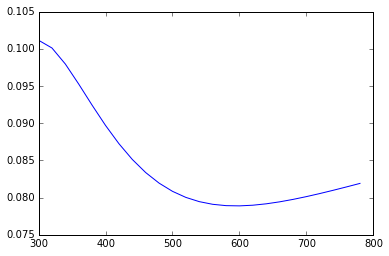

In [24]:
wl=range(300,800,20)
plt.plot(wl,[Reflectance3(air,Layer(sub,100000),air,[layer],0.2,x,Pol.sp) for x in wl])